Import client code.

In [1]:
# import logging
# reload(logging) # This is required for ipython notebook
# The error is reported using logging module

In [2]:
class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print '[%s]' % self.name,
        print 'Elapsed: %s' % (time.time() - self.tstart)

In [3]:
import os, sys
sys.path.append('..')
import ue4cv

Connect to the game

In [4]:
ue4cv.client.connect() # Make sure unrealcv server can detect client disconnection
request = ue4cv.client.request

Can not connect to ('localhost', 9000)
Error [Errno 10061] No connection could be made because the target machine actively refused it


In [5]:
print ue4cv.client.request('vset /mode/lit')
# If the logger set its own handler, it won't be effect by the ipython notebook config
# client2.request('vset /mode/depth')

Fail to send message, client is not connected


None


Define a function to read message from text file

In [71]:
def read_camera_info(filename):
    with open(filename) as f:
        lines = f.readlines()
    # Parse camera location and rotation from file
    camera_pos = []
    for line_id in range(len(lines)):
        line = lines[line_id].strip() # Remove \n at the end
        if line_id % 3 == 0: # filename
            pass
        elif line_id % 3 == 1: # location
            location = [float(v) for v in line.split(' ')]
        elif line_id % 3 == 2: # Rotation
            rotation = [float(v) for v in line.split(' ')]
            camera_pos.append((location, rotation))
    return camera_pos

camera_pos = read_camera_info('./realistic_rendering_camera_info.txt')

Define a function to render images

In [73]:
import time
def render_frame(pos):
    loc = pos[0] # location
    rot = pos[1] # rotation
    cmd = 'vset /camera/0/location %.3f %.3f %.3f' % (loc[0], loc[1], loc[2])
    response = request(cmd)
    assert response == 'ok'
    cmd = 'vset /camera/0/rotation %.3f %.3f %.3f' % (rot[0], rot[1], rot[2])
    response = request(cmd)
    assert response == 'ok'
    files = []
    f1 = request('vget /camera/0/lit')
    f2 = request('vget /camera/0/depth')
    f3 = request('vget /camera/0/object_mask')
    f4 = request('vget /camera/0/normal')

    return [f1, f2, f3, f4]

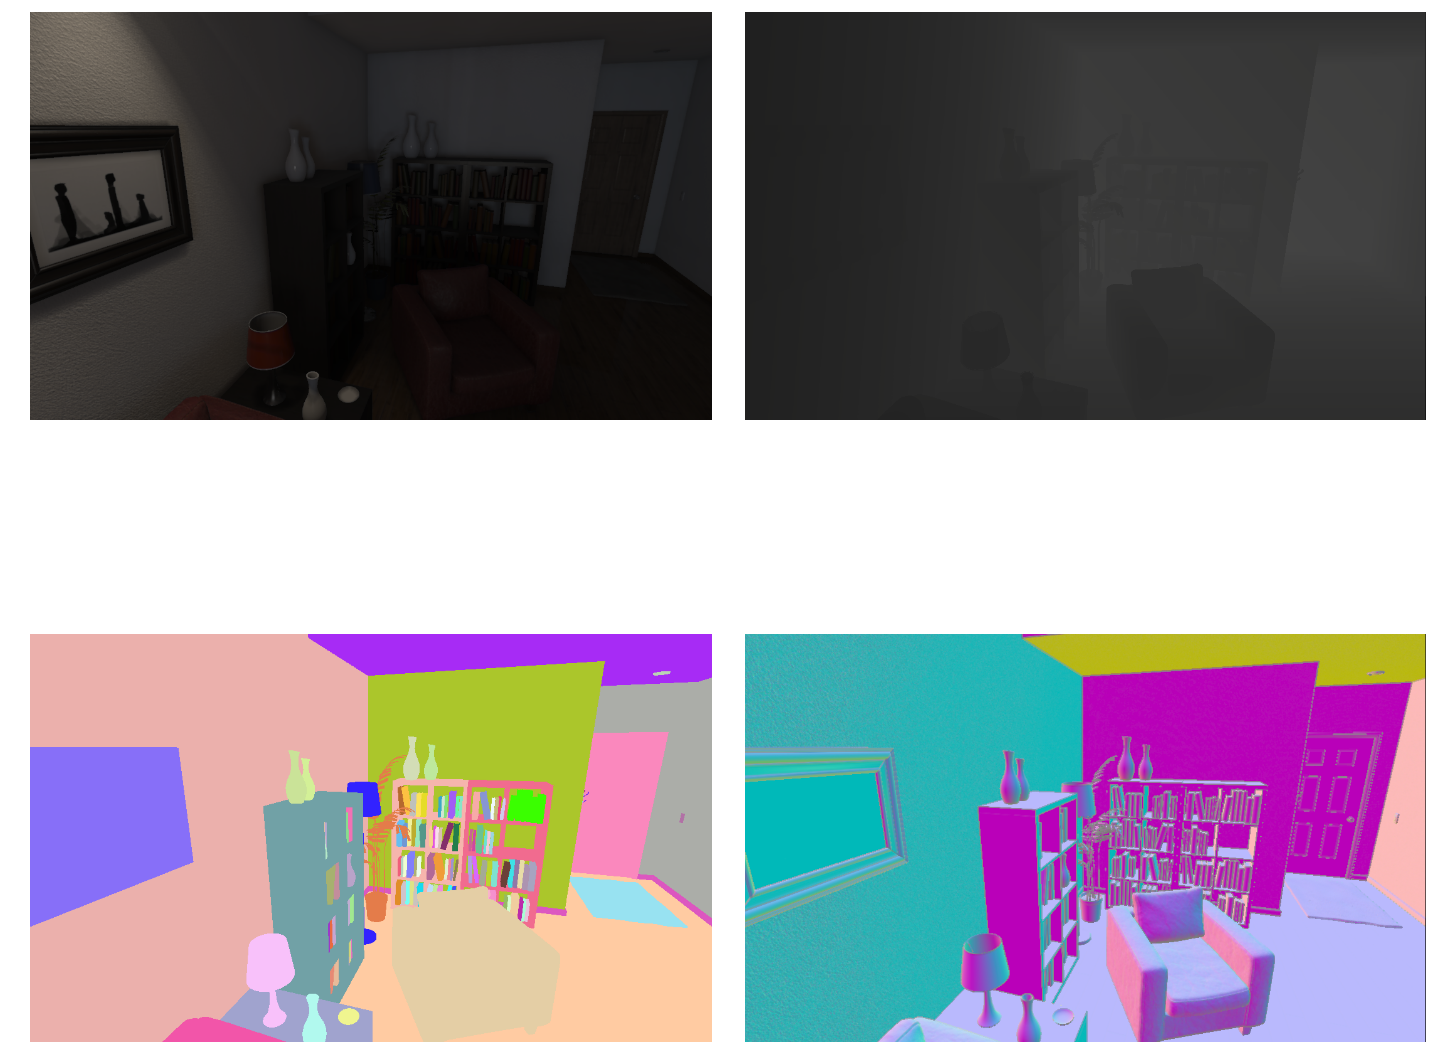

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 20.0)

pos = camera_pos[1]
files = render_frame(pos)
N = len(files)
for i in range(N):
    plt.subplot(N/2,2,i+1)
    im = plt.imread(files[i])
    plt.imshow(im)
    plt.axis('off')
plt.tight_layout()

In [83]:
%timeit
objects = request('vget /objects').split(' ')
print objects[:5]

['Carpet_5', 'SM_CoffeeTable_14', 'Couch_13', 'SM_Room_7', 'SM_Room_OuterShell_14']


In [89]:
# Get the color mapping for each object
objname = objects[0]
request('vget /object/%s/color' % objname)

with Timer():
    color_mapping = {}
    for objname in objects:
        color_mapping[objname] = request('vget /object/%s/color' % objname)

    print color_mapping


{'': 'error Object  not exist', 'SM_Door_39': '(R=245,G=64,B=132,A=255)', 'BookLP_45': '(R=90,G=10,B=43,A=255)', 'BookLP_153': '(R=224,G=93,B=194,A=255)', 'EditorPlane_26': '(R=63,G=119,B=127,A=255)', 'EditorPlane_27': '(R=108,G=116,B=0,A=255)', 'EditorPlane_24': '(R=84,G=187,B=41,A=255)', 'EditorPlane_25': '(R=93,G=155,B=43,A=255)', 'BookLP_130': '(R=144,G=128,B=51,A=255)', 'EditorPlane_23': '(R=23,G=91,B=68,A=255)', 'SM_CoffeeTable_14': '(R=191,G=22,B=2,A=255)', 'SlidingDoors_5': '(R=16,G=25,B=104,A=255)', 'BookLP_31': '(R=92,G=245,B=87,A=255)', 'BookLP_53': '(R=138,G=184,B=233,A=255)', 'SM_Bowl_27': '(R=110,G=141,B=195,A=255)', 'Mug_22': '(R=36,G=30,B=118,A=255)', 'SM_FloorLamp_7': '(R=7,G=3,B=255,A=255)', 'SM_Bowl_28': '(R=223,G=168,B=117,A=255)', 'SM_FloorLamp_5': '(R=15,G=223,B=223,A=255)', 'BookLP_139': '(R=142,G=69,B=87,A=255)', 'SM_Railing_27': '(R=166,G=104,B=215,A=255)', 'SM_BlackBox_27': '(R=215,G=143,B=128,A=255)', 'SM_Railing_25': '(R=173,G=118,B=110,A=255)', 'SM_Railing_

In [88]:
with Timer():
    response = request('vrun ls')
    print response

vrun [str]
Run an alias for Unreal CV plugin
vget /camera/[uint]/location
Get camera location
vget /camera/[uint]/rotation
Get camera rotation
vset /camera/[uint]/location [float] [float] [float]
Set camera location
vset /camera/[uint]/rotation [float] [float] [float]
Set camera rotation
vget /camera/[uint]/view
Get snapshot from camera
vget /camera/[uint]/[str]
Get snapshot from camera
vget /unrealcv/port
Get port from the plugin listening to
vset /unrealcv/port [uint]
Set port the plugin listening to
vget /unrealcv/status
Get camera location
vset /mode/[str]
Set mode
vget /mode
Get mode
vget /objects
Get all objects in the scene
[str] /object/_/[str]
Get current object
vget /object/[str]/color
Get object color
vset /object/[str]/color
Set object color
vget /object/[str]/name
Get object name
vget /util/get_commands
Get all available commands

Elapsed: 0.3140001297
